In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Navigation Equations

$state  \rightarrow \mathbf{x} $
 
 $\mathbf{x} = \{p_x, p_y, p_z,v_x, v_y, v_z, q_x, q_y, q_z, q_w\}^T $  , $ \mathbf{x} \in \mathbb{R}^{10}$


$ measurement(IMU) \rightarrow \mathbf{\tilde{u}}$  

$ \mathbf{\tilde{u}}= \{a_x, a_y, a_z, \omega_x,\omega_y,\omega_z\}^T \triangleq \{ \mathbf{s}, \boldsymbol{\omega}\} $, $ \mathbf{\tilde{u}} \in\mathbb{R}^{6} $    </br>

*accelerometers are meant to detect external accelerations (and rotations) in the Body refence frame ($\mathcal{B}$).<br> Obviously GPS will provide any position information in an absolute reference frame:* ($\mathcal{N}$)

*where:*
$ \mathbf{v} \lvert_{\mathcal{N}} =  \mathbf{R}^n_b (\mathbf{q})   \mathbf{v} \lvert_{\mathcal{B}}$


1. $\mathbf{p_k} = \mathbf{p_{k-1}} + T_s \mathbf{v_{k-1}} + (T_s^2) [ \mathbf{R_b^n}(\mathbf{q_{k-1}})\mathbf{s_{k-1}} - \mathbf{g}]$ *(position in $\mathcal{N}$ reference frame)*

<br>

2. $\mathbf{v_k} = \mathbf{v_{k-1}} + (T_s) [ \mathbf{R_b^n}(\mathbf{q_{k-1}})\mathbf{s_{k-1}} - \mathbf{g} ] $ *(velocity in $\mathcal{N}$ reference frame)*

<br>

3. $\mathbf{q_k} =  [ cos(\frac{1}{2} \frac{T_s}{\lvert\lvert \boldsymbol{\omega} \lvert\lvert^2}) \mathbf{I_4} +sin(\frac{1}{2} \frac{T_s}{\lvert\lvert \boldsymbol{\omega} \lvert\lvert^2}) \boldsymbol{\Omega_k}] \mathbf{q_{k-1}} $ 
   
   (*quaternion's kinematic. **NB**: this quaternions are the ones for rotation: $\mathcal{B} \rightarrow \mathcal{N}$*)

*where* $\boldsymbol{\Omega_k} = \left[\begin{array} {c,c,c,c}
                                         0 ,\omega_z , -\omega_y , \omega_x \\
                                        -\omega_z , 0 , \omega_x , \omega_y \\
                                        \omega_y , -\omega_x , 0 , \omega_z \\
                                        -\omega_x , -\omega_y , -\omega_z ,0 
                                        \end{array} \right]$
        
 *and* $\mathbf{R_b^n}(\mathbf{q}) = \left[\begin{array} {c,c,c}
                                           q_w^{2}+ q_x^2− q_y^2 − q_z^2, ... ,.. \\
                                           ..., ... , ... \\
                                           ..., ...., ...
                                             \end{array} \right]$
                                             
 $\small{refer \quad to : \text{http://www.tu-berlin.de/fileadmin/fg169/miscellaneous/Quaternions.pdf}}$

**NOTE:** *implemented algortithm avoid singularity*: $q_x^{2} + q_w^{2} + q_x-q_w = 0$

##### Error model: 
*IMU sensor model is modeled as the sum of a bias error plus an addictive white noise.*

$ \mathbf{\tilde{u}} = \mathbf{u} - \mathbf{\delta u}_k + \mathbf{w}^{(1)}$
<br> *where*<br>
$\mathbf{u} \rightarrow \text{measurement's ground truth}$<br>
$\mathbf{\tilde{u}} \rightarrow \text{ sensor's measurement}$<br>
$\mathbf{\delta u}_k  \rightarrow \text{ slowly varyiang bias error}$<br>

   IMU's biased error is modeled as a **random-walk** process:<br>
$ \mathbf{\delta u}_k = \mathbf{\delta u}_{k-1} + \mathbf{w}^{(2)} $<br>
<br>
    The $\delta u$ error will be tracked in the Kalman filter
     
     
  *Moreover $\mathbf{w}^{(1)}$ and $\mathbf{w}^{(2)}$ are uncorrelated with covariance matrices: $\mathbf{Q^{(1)}}, \mathbf{Q^{(2)}}$respectively*
________________________________________

In [13]:
def q2DCM(q, orthogonalize = True):
    
    p = np.zeros([6,1])
    p[:4] = q**2
    p[4] = p[1] + p[2]
   
    
    
    if p[0] + p[3] + p[4] != 0:
        p[5] = 2/(p[0] + p[3] + p[4])
    else:
        p[5] = 0

    R = np.zeros((3,3))
    
    R[0,0] = 1- p[5] * p[4]
    R[1,1] = 1- p[5] *( p[0] + p[2])
    R[2,2] = 1- p[5] *( p[0] + p[1])
    
    p[0] = p[5] * q[0]
    p[1] = p[5] * q[1]
    p[4] = p[5] * q[2] * q[3]
    p[5] = p[0] * q[1]
    
    R[0,1] = p[5] - p[4]
    R[1,0] = p[5] + p[4]
    
    p[4] = p[5] * q[3]
    p[5] = p[0] * q[2]
    
    R[0,2] = p[5] + p[4]
    R[2,0] = p[5] - p[4]
    
    p[4] = p[0] * q[3]
    p[5] = p[1] * q[2]
    
    R[1,2] = p[5] - p[4]
    R[2,1] = p[5] + p[4]
    
    if orthogonalize:
        R = 3./2.* R - np.dot(R,np.dot(R.T, 1./2. * R ))
    return R

def DCM2q(R,normalize = True):
    
    q= np.zeros([4,1])
    
    if (1 + R[0,0] + R[1,1] + R[2,2]) > 1e-6:
        q[3] = 0.5 * np.sqrt(1 + R[0,0] + R[1,1] + R[2,2])
        q[0] = (R[2,1] - R[1,2])/(4*q[3])
        q[1] = (R[0,2] - R[2,0])/(4*q[3])
        q[2] = (R[1,0] - R[0,1])/(4*q[3])
    
    if normalize:
        
        qn = np.sqrt(q[0,0]**2 + q[1,0]**2 + q[2,0]**2 + q[3,0]**2 )
        if qn > 1e-6:
            q /= qn
        
    return q



# orthogonality-test
t = np.pi/3#np.pi/3;
R1 = np.array([[np.cos(t),-np.sin(t),  0],
               [+np.sin(t),np.cos(t), 0],
               [  0       ,     0   , 1]])

R = R1

print(R)
q = DCM2q(R)
print(np.linalg.norm(q))
print(q)
R_ = q2DCM(DCM2q(R))

print(R-R_)
print(np.linalg.norm(R-R_))

print(np.dot(R.T,R))


[[ 0.5       -0.8660254  0.       ]
 [ 0.8660254  0.5        0.       ]
 [ 0.         0.         1.       ]]
1.0
[[0.       ]
 [0.       ]
 [0.5      ]
 [0.8660254]]
[[2.77555756e-16 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.77555756e-16 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
3.925231146709438e-16
[[ 1.00000000e+00 -1.48741681e-17  0.00000000e+00]
 [-1.48741681e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [14]:
def gravity(l,h):
  
    #l -> Latitude [degrees]
    #h -> Altitude [m]
    
    l =np.pi/180*l;

    gamma=9.780327*(1+0.0053024*np.sin(l)**2-0.0000058*np.sin(2*l)**2);

    g=gamma-((3.0877e-6)-(0.004e-6)*np.sin(l)**2)*h+(0.072e-12)*h**2;

    g = np.array([0, 0, -g]);
    g = np.reshape(g,[3,1])
    
    return g 
             
gravity(59,0)

array([[ 0.        ],
       [ 0.        ],
       [-9.81838559]])

In [15]:
def nav_equations(x, u, dt, l = 59, h = 0):
    
    ######### Recasting
    #position + velocity and quaternion
    pv = x[:6].reshape(6,1)
    """print("pv =>\n",pv)"""
    q = x[6:].reshape((4,1))
    """print("q=> \n",q)"""
    

    #acceleration and omega
    s = u[:3]
    w = u[3:]
    
    #compute gravity vector 
    gt = gravity(l,h)
    
    ######### Translation 
    #Rotation matrix (from quaternions) => compute acceleration acting on the system
    
    R = q2DCM(q)
    ft = np.dot(R,s) 
    acc_t = ft - gt
   
    #Integator matrices A,B  => x[t] = A * x[t-1] + B * ft[t]
    A = np.eye(6)
    A[0,3] = dt
    A[1,4] = dt
    A[2,5] = dt 
    

    B = np.concatenate((np.eye(3,3) * (dt**2)/2, np.eye(3,3) * dt))#np.block([(dt**2)/2 * np.eye(3,3) , dt * np.eye(3,3)])
    
    pv = np.dot(A,pv) + np.dot(B,acc_t);
    
    ######### Rotation
    #Matrices implementing quaternions kinematic.
    I4 = np.eye(4)
    wn = np.sqrt(w[0,0]**2 + w[1,0]**2 + w[2,0]**2)
    w_X = 0.5*dt* np.array([[0    , w[2,0] , -w[1,0] , w[0,0] ],
                         [-w[2,0], 0    ,  w[0,0] , w[1,0] ],
                         [ w[1,0], -w[0,0],   0   , w[2,0] ],
                         [-w[0,0], -w[1,0],  -w[2,0],  0   ]])
    
    if wn >0:
        v = wn *dt
        Aq = (np.cos(1/2 * v) * I4 + 2/v * np.sin(1/2 * v) * w_X)
        q_ = np.dot(Aq,q)
    
    ######### Update stat
    x_ = np.array([pv[0,0], pv[1,0],pv[2,0], pv[3,0],pv[4,0], pv[5,0],q_[0,0],q_[1,0],q_[2,0],q_[3,0]]).reshape((10,1))

    return x_ 


### test-1: propagate a generic state
dt = 1
th = 0#np.pi/3;
Rt = np.array([[np.cos(th),-np.sin(th),  0],
               [+np.sin(th),np.cos(th), 0],
               [  0       ,     0   , 1]])
qt = DCM2q(Rt)
xt_ = np.array([0,0,0,0,0,0,qt[0,0],qt[1,0],qt[2,0],qt[3,0]])
xt_ = xt_.reshape(10,1)


ut = np.array([1.0,0,+gravity(59,0)[2,0],0,0,1.]).reshape(6,1)
xt = nav_equations(xt_,ut,dt)
print(xt_)
print( " \n-----------------\n ")
print( ut," \n=================> \n")
print( xt)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
 
-----------------
 
[[ 1.        ]
 [ 0.        ]
 [-9.81838559]
 [ 0.        ]
 [ 0.        ]
 [ 1.        ]]  
=================> 

[[0.5       ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.47942554]
 [0.87758256]]


____________________________________________________________________

## State-Space Equations

*Instead of filetering the proper system's dynamic (which can always be filtered separately), the current implementation apply the filter to errors dynamic.*

$ \mathbf{z}_k = \{\mathbf{\delta x}, \mathbf{\delta u}\} \in \mathbb{R}^{15} $
    $ \Rightarrow$
    
$ \mathbf{z} =\{\mathbf{\delta p_{3 \times 1}},
                \mathbf{\delta v_{3 \times 1}},
                \boldsymbol{\delta \epsilon_{3 \times 1}} \lvert
                \mathbf{\delta s^{bias}_{3 \times 1}}
                \mathbf{\delta \omega^{bias}_{3 \times 1}}\}  $
                
*as*
$\mathbf{\dot{z}_k} = F(\mathbf{z}_{k-1}) \mathbf{z}_{k-1} + G(\mathbf{z}_{k-1}) \mathbf{w}_{k}$ <br>


***where***: <br>
*1. Rotation error $\epsilon$ is represented under **small-rotations** assumption* 
 
$\boldsymbol{\delta \epsilon } \quad  s.t. \quad \exists \quad \Gamma (\mathbf {q}, \boldsymbol{\epsilon}) \triangleq \{ \mathbf{q} \in SO^3 \quad \lvert \quad \mathbf{R_b^n}(\mathbf{q}) = [\mathbf{I_3} - [\boldsymbol{\epsilon}]_{\times} ] \mathbf{R_b^n}(\mathbf{\hat{q}})   \} $

$[\mathbf{\epsilon}]_{\times}=\left[\begin{array} {c,c,c}
                                           0, \epsilon_y , -\epsilon_z \\
                                           \epsilon_z, 0 , \epsilon_x \\
                                           \epsilon_x, -\epsilon_y, 0
                                             \end{array} \right]$
                                             
                                             
*As the filter computes small (infinitestimal) rotations errors the corrections on quaternions must be performed as follow:*

$\quad \boldsymbol{\delta \epsilon} \quad \rightarrow  \quad
\mathbf{R_b^n}(\mathbf{\hat{q}}) = (\mathbf{I}_3 - [\mathbf{\epsilon}]_{\times} )\mathbf{R_b^n}(\mathbf{q}) \quad  \rightarrow \quad  \mathbf{\hat{q}} \quad \tiny{\text{ ( final step to be performed with DCM2q) }} $


                                              

*2. estimation error:* <br> 

$ \mathbf{\delta x} = \mathbf{\hat{x}} - \mathbf{x} $ 
( * estimated - true *),
<!-- $\mathbf{\delta u} = \mathbf{\hat{u}} - \mathbf{u} $-->




<img src="./Loosely_coupled_Kf.png"/>


**NOTE-1**: *the filter is going to correct the error relying on GPS measurement, therefore the covariance of observation noise ($\mathbf{R}$) is equal to the GNSS measurement's uncertainty* 

**NOTE-2**: *the step 'update attitude' is performed through $\Gamma$*




________________________________________________________________________


In [16]:
def Gamma(q_,eps):
    
    R_ = q2DCM (q_)
    eps_X = np.array([[0        , -eps[2,0], eps[1,0]],
                      [eps[2,0], 0        , -eps[0,0]],
                      [-eps[1,0], eps[0,0] ,    0    ]])
    
    I3 = np.eye(3);
    
    """
    print("R_",R_)
    print("eps_X",eps_X)
    """
    R = np.dot((I3 - eps_X),R_)
    
    return DCM2q(R)
    
    

In [17]:
def state_space(x,u,dt):
    
    #state
    q = x[6:]
    Rb2n = q2DCM(q)
    
    #measurement
    s = u[:3]
    ft = np.dot(Rb2n,s)
   
    
    ft_X = np.array([[0    , -ft[2,0], ft[1,0] ],
                     [ft[2,0],   0   , -ft[0,0]],
                     [-ft[1,0], ft[0,0],   0   ]])
    
    
    
    #Matrices creation:
    O = np.zeros((3,3))
    I = np.eye(3)
    
    Fc = np.block([[O, I ,  O,     O,    O],
                   [O, O,  ft_X,  Rb2n,  O],
                   [O, O,  O,      O,-Rb2n],
                   [O, O ,  O,     O,    O],
                   [O, O ,  O,     O,    O]])#size 15 X 15
    
    F = np.eye(15,15) + dt * Fc
    
    G= np.block([[ O       ,  O , O ,O ],
                 [ dt*Rb2n ,  O , O ,O ],
                 [ O,   -dt*Rb2n, O ,O ],
                 [ O,      O    , I ,O ],
                 [ O,      O    , O ,I ]])#size 15 X 12
    
    
    
    
    return F,G
    
    

Ft, Gt = state_space(xt,ut,dt)

zt_ = np.ones((15,1))# KF-stat
wt = np.ones((12,1))#white noise vector
dz_test_t = np.dot(Ft,zt_) + np.dot(Gt,wt)
"""print(dz_test_t, dz_test.shape)"""


# S.S. equations test:

F_test_kth= np.array([
             [      1.0000  ,      0   ,     0  , 0.1000   ,     0   ,     0    ,    0    ,    0    ,    0    ,    0   ,     0   ,     0  ,      0  ,      0  ,      0],
             [           0  , 1.0000   ,     0  ,      0   ,0.1000   ,     0    ,    0    ,    0    ,    0    ,    0   ,     0   ,     0  ,      0  ,      0  ,      0],
             [           0  ,      0   ,1.0000  ,      0   ,     0   ,0.1000    ,    0    ,    0    ,    0    ,    0   ,     0   ,     0  ,      0  ,      0  ,      0],
             [           0  ,      0   ,     0  , 1.0000   ,     0   ,     0    ,    0    ,    0    , 0.1000  , 0.0000 , -0.1000 ,     0  ,      0  ,      0  ,      0],
             [           0  ,      0   ,     0  ,      0   ,1.0000   ,     0    ,    0    ,    0    , -0.0000 ,  0.1000,   0.0000,     0  ,      0  ,      0  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,1.0000    ,-0.1000  , 0.0000  ,    0    ,    0   ,     0   ,0.1000  ,      0  ,      0  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,1.0000   ,    0    ,    0    ,    0   ,     0   ,     0  ,-0.0000  , 0.1000  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,1.0000   ,    0    ,    0   ,     0   ,     0  ,-0.1000  ,-0.0000  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,    0    , 1.0000  ,    0   ,     0   ,     0  ,      0  ,      0  ,-0.1000],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,    0    ,    0    ,1.0000  ,     0   ,     0  ,      0  ,      0  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,    0    ,    0    ,    0   ,  1.0000 ,     0  ,      0  ,      0  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,    0    ,    0    ,    0   ,     0   ,1.0000  ,      0  ,      0  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,    0    ,    0    ,    0   ,     0   ,     0  ,1.0000   ,      0  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,    0    ,    0    ,    0   ,     0   ,     0  ,      0  , 1.0000  ,      0],
             [           0  ,      0   ,     0  ,      0   ,     0   ,     0    ,    0    ,    0    ,    0    ,    0   ,     0   ,     0  ,      0  ,      0  , 1.0000]]).reshape((15,15))



G_test_kth = np.array([[0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0,0,0,0,0],
                      [0.0000,-0.1000,0,0,0,0,0,0,0,0,0,0],
                      [0.1000, 0.0000,0,0,0,0,0,0,0,0,0,0],
                      [0,0, 0.1000,0,0,0,0,0,0,0,0,0],
                      [0,0,0,-0.0000, 0.1000,0,0,0,0,0,0,0],
                      [0,0,0,-0.1000,-0.0000,0,0,0,0,0,0,0],
                      [0,0,0,0,0,-0.1000,0,0,0,0,0,0],
                      [0,0,0,0,0,0, 0.1000,0,0,0,0,0],
                      [0,0,0,0,0,0,0, 0.1000,0,0,0,0],
                      [0,0,0,0,0,0,0,0, 0.1000,0,0,0],
                      [0,0,0,0,0,0,0,0,0, 0.1000,0,0],
                      [0,0,0,0,0,0,0,0,0,0, 0.1000,0],
                      [0,0,0,0,0,0,0,0,0,0,0, 0.1000]]).reshape((15,12))


x_test = np.array([1.0000,1.0000,0,0.1000,0.1000,0,0,0,0.7071,0.7071]).reshape((10,1))
u_test =np.array([[1],[0],[0],[1],[2],[0]])
dt_test = 0.1
F_test, G_test = state_space(x_test,u_test,dt_test)

print(np.linalg.norm(G_test - G_test_kth))
print(np.linalg.norm(F_test - F_test_kth))

print(np.max(F_test - F_test_kth))
print(np.max(G_test - G_test_kth))

2.2045407685048604
2.719479911021037e-17
1.1102230246251566e-17
0.9


In [18]:
class KalmanFilterLooselyIMUGNNS:
    def __init__( self,
                  gamma_fcn = Gamma,#Gamma function=> quaternions correction
                  nav_eq_fcn = nav_equations,#Assumed navigation equations => might change depending on applications
                  state_space_fcn = state_space,# KF state-space equations
                  x0 = np.zeros((10,1)),
                  z0 = np.zeros((15,1)),
                  delta_uh_ = np.zeros((6,1)),
                  Ts_ = 0.1,
                  sigma_acc = 0.050000,sigma_gyro = 1.7453e-03,
                  sigma_acc_bias = 1.0000e-04,sigma_gyro_bias = 1.7453e-04,
                  sigma_gps = 1.7321,
                  p_uncertainty = 10, v_uncertainty = 5, rpy_sm_uncertainty = np.pi/180*np.array([1,1,20]),
                  acc_uncertainty = 0.02, gyro_uncertainty = 0.05*np.pi/180
                 ):
        
        
        #Set equations
        self.Gamma = gamma_fcn
        self.NavEq = nav_eq_fcn
        self.StateSpace = state_space_fcn
        
        #Support matrices 
        O3 = np.zeros((3,3))
        O6 = np.zeros((6,6))
        I3 = np.eye(3)
        
        #Noise covariance
        self.Q1 = np.block([[sigma_acc**2 * np.ones((3,3)),         O3               ],
                            [         O3             ,sigma_gyro**2 * np.ones((3,3)) ]])
        """print(self.Q1, self.Q1.shape)"""
        #Bias' Noise covariance
        self.Q2 = np.block([[sigma_acc_bias**2 * I3,               O3                 ],
                            [         O3             ,sigma_gyro_bias**2 * np.eye(3)  ]])
        
        #Noise matrix
        self.Q = np.block([[self.Q1, O6],
                           [O6, self.Q2]])
        
        """print(self.Q1, self.Q1.shape)"""
        #State Uncertainty
        rpy_mat = np.array([[rpy_sm_uncertainty[0]**2,              0         ,                 0       ],
                            [               0        ,rpy_sm_uncertainty[1]**2,                 0       ],
                            [0                       ,           0            , rpy_sm_uncertainty[2]**2]])
        
        self.P = np.block([[p_uncertainty**2 *I3 ,          O3        ,   O3    ,          O3 ,                    O3    ],
                           [       O3            ,v_uncertainty**2 *I3,   O3   ,           O3,                     O3    ],
                           [       O3            ,          O3        , rpy_mat,           O3,                     O3    ],
                           [       O3            ,          O3        ,    O3,   acc_uncertainty**2 * I3,          O3    ],
                           [       O3            ,          O3        ,    O3,              O3,  gyro_uncertainty**2 * I3]
                          ])
        
        
        """print(self.P, self.P.shape)"""
        #GNSS noise 
        self.R = sigma_gps**2 * I3
        
        #observation matrix
        self.H = np.block([[I3, O3, O3, O3, O3]])
        """print(self.H, self.H.shape)"""
        
        #init KF-state, init error correction,  init measurement , init sampling time
        self.z = z0;
        self.x = x0;
        self.delta_uh = delta_uh_ 
        self.uh = np.zeros((6,1))
        self.Ts = Ts_
        
        # init KF gain
        self.K = self.compute_gain()#np.zeros((15,3))#np.linalg.solve(np.dot(self.P,self.H.T) , np.dot(self.H, np.dot(self.P,self.H.T)) + self.R)
        
    def calibrate(self,u):
        self.uh = u + self.delta_uh
        
    def predict(self, dt = None):
        
        if dt is None:
            dt = self.Ts
            
        """print("X before",self.x)"""
        self.x = self.NavEq(self.x,self.uh,dt)
        """print("X after",self.x)"""
        F,G = self.StateSpace(self.x,self.uh,dt)
        self.P = np.dot(F , np.dot(self.P , F.T)) + np.dot( G, np.dot(self.Q, G.T))
            
            
    def compute_gain(self):
            
        S =  np.dot(self.H, np.dot(self.P,self.H.T)) + self.R
        """print("S",S)"""
        """S_inv = np.linalg.inv(S)"""
        """print("Sinv",S_inv)"""
        A = np.dot(self.P,self.H.T) 
        KT = np.linalg.solve(S,A.T)
        self.K = KT.T #np.linalg.solve(A,S)#np.dot(np.dot(self.P,self.H.T),S_inv) 
        
    def update(self,y):
       
        """print("x before", self.x)"""
        
        H_sub = self.H[:,:6]
            
        pv = self.x[:6]
        q = self.x[6:10]
        
        z_ = np.array([0,0,0,0,0,0,0,0,0,self.delta_uh[0,0],self.delta_uh[1,0],
                                         self.delta_uh[2,0],self.delta_uh[3,0],
                                         self.delta_uh[4,0],self.delta_uh[5,0]]).reshape(15,1) 
        
        
        self.z = z_ + np.dot( self.K, y - np.dot(H_sub, pv))
        
        """print("{z} full state after \n",self.z)"""
            
        eps = self.z[6:9]
        delta_pv = self.z[:6]
        
        """print("{pos,vel} correction \n",delta_pv)"""
        """print("{eps} correction \n",eps)"""
        
        self.x[:6] = self.x[:6]  + delta_pv
        

        self.x[6:] = self.Gamma(q,eps)
        
        """print("x after", self.x) """
        
        self.delta_uh = self.z[9:]
        
        self.P = np.dot(np.eye(15) - np.dot(self.K, self.H), self.P)
    

### Sensor class

Following structure is assumes to store a sensor data.



In [19]:
class SensorData:
    delimiter = ","

    def __init__(self,datafile_,name):
        self.__data = np.loadtxt(datafile_, delimiter = SensorData.delimiter)
        self.__time = self.__data[:,0]
        self.__readings = self.__data[:,1:]
        
        self.name = name
        self.tmax = self.__time[-1];
        
        self.Ts = 0
        self.Qcov = None
        self.last_idx = 0
        
        for i in range(len(self.__time[1:])):
            dt = self.__time[i] - self.__time[i-1]
            if dt > self.Ts:
                self.Ts = dt
            
    def __getitem__(self,idx):
        try:
            assert(idx < len(self.__time))
        except IndexError:
            
            print("OUT OF RANGE")
            return None , None
        
        return self.__readings[idx]
    
    
    def t(self,idx):
        
        try:
            assert(idx < len(self.__time))
        except IndexError:
            print(" TIME OUT OF RANGE")
            return None , None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
        
        return float(self.__time[idx])

    def at(self, t, check_only = False):
        # TODO: Enable Check for GNSS availability
        
        if t in self.__time:
            for it, t_ in enumerate(self.__time.tolist()):
                if t_ == t:
                    return self.__data[it]
        
        else:
            return None
        
        
    def plot(self):
        names = [self.name +'_1', self.name +'_2', self.name +'_3']
        plt.plot(self.__time,self.__readings)
        plt.legend(names)
        plt.xlabel('time(s)')
        plt.ylabel('readings')
        plt.show()
        
    def reset_index(self):
        self.last_idx =0
        
        
    def gettime(self):
        return self.__time
    
    def getdata(self):
        return self.__readings
    
    def sigma_fit(self):
        print(np.cov(self.__readings))

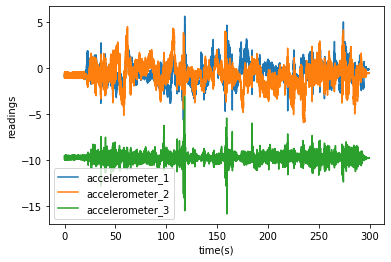

In [20]:
accelerometer = SensorData(os.getcwd()+'/Data/ACC_data.csv',"accelerometer")
accelerometer.plot()

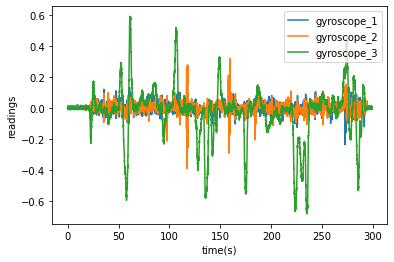

In [21]:
gyroscope = SensorData(os.getcwd()+'/Data/GYRO_data.csv',"gyroscope")
gyroscope.plot()

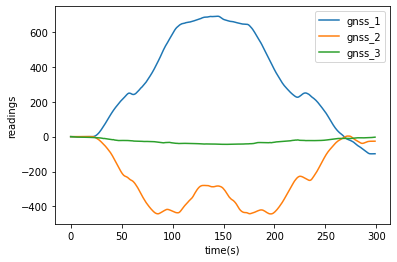

In [22]:
gnss = SensorData(os.getcwd()+'/Data/GNSS_data.csv',"gnss")
gnss.plot()

### Program:

In [29]:
steps = accelerometer.getdata().shape[0]
t_imu_k_ = accelerometer.t(0)

kf = KalmanFilterLooselyIMUGNNS(nav_eq_fcn= nav_equations,
                                Ts_= 0.1,
                                x0 = np.array([ 0,0 ,0 ,0 ,0 ,0  ,0.0214 , -0.0539 , -0.3399 , 0.9387]).reshape(10,1) )

df = pd.DataFrame(columns = ['t','ax','ay','az','wx','wy','wz','px_gnss','py_gnss','pz_gnss',#sensors
                             'px','py','pz','vx','vy','vz','q1','q2','q3','q4'#recontstucted state
                            ])

k_gnss = 0;
for i in range(1,int(steps/2)): #range(1,400):#
    
    t_imu_k = accelerometer.t(i)
    dt_imu = t_imu_k - t_imu_k_
    t_imu_k_ = t_imu_k
    
    u = np.array([accelerometer[i],gyroscope[i]]).reshape(6,1)
    #print("u",u)
    kf.calibrate(u)
    kf.predict(dt_imu)
    
    if gnss.at(t_imu_k) is not None:
        print("....................................................")
        print("gnss, @time= ",gnss.t(k_gnss),"@pos= ",gnss[k_gnss])
       
        
        y = gnss[k_gnss].reshape(3,1)
        
        kf.compute_gain()
        kf.update(y)
        
        k_gnss+=1
        
        print("....................................................")
        
        
    else:
        y = np.array([np.NaN,np.NaN,np.NaN]).reshape(3,1)
        
        
    df = df.append(pd.Series([t_imu_k,
                    u[0,0],u[1,0],u[2,0],u[3,0],u[4,0],u[5,0],
                    y[0,0],y[1,0],y[2,0],
                    kf.x[0,0],kf.x[1,0],kf.x[2,0],kf.x[3,0],kf.x[4,0],kf.x[5,0],kf.x[6,0],kf.x[7,0],kf.x[8,0],kf.x[9,0]],index=df.columns),
                    ignore_index=True)
    
    

....................................................
gnss, @time=  0.110000000000014 @pos=  [ 0.  0. -0.]
....................................................
....................................................
gnss, @time=  1.11000000000001 @pos=  [-0.22280477  0.05689071 -0.42300001]
....................................................
....................................................
gnss, @time=  2.11000000000001 @pos=  [-4.45609500e-01  1.16415322e-10 -1.05300002e+00]
....................................................
....................................................
gnss, @time=  3.11000000000001 @pos=  [-5.57011842e-01  1.16415322e-10 -1.43800003e+00]
....................................................
....................................................
gnss, @time=  4.11000000000001 @pos=  [-7.79816540e-01  1.16415322e-10 -1.74200005e+00]
....................................................
....................................................
gnss, @time=  5.11000000

....................................................
gnss, @time=  48.11 @pos=  [ 196.40633602 -186.24987609  -22.3647344 ]
....................................................
....................................................
gnss, @time=  49.11 @pos=  [ 203.09098852 -196.6030725   -22.13425355]
....................................................
....................................................
gnss, @time=  50.11 @pos=  [ 209.33002753 -206.27361204  -21.80975978]
....................................................
....................................................
gnss, @time=  51.11 @pos=  [ 215.12339235 -214.57883747  -21.89422573]
....................................................
....................................................
gnss, @time=  52.11 @pos=  [ 220.80527632 -221.17743099  -21.8886446 ]
....................................................
....................................................
gnss, @time=  53.11 @pos=  [ 227.26685144 -225.50047513  -21.8

....................................................
gnss, @time=  96.11 @pos=  [ 549.67982663 -417.62885919  -32.6733075 ]
....................................................
....................................................
gnss, @time=  97.11 @pos=  [ 559.70619796 -419.56173177  -32.83530537]
....................................................
....................................................
gnss, @time=  98.11 @pos=  [ 569.73250595 -421.89268701  -34.21034583]
....................................................
....................................................
gnss, @time=  99.11 @pos=  [ 579.87027824 -424.45117218  -35.14842811]
....................................................
....................................................
gnss, @time=  100.11 @pos=  [ 590.23091151 -427.35092131  -35.87157091]
....................................................
....................................................
gnss, @time=  101.11 @pos=  [ 600.36871191 -429.96627459  -36

....................................................
gnss, @time=  144.11 @pos=  [ 689.47563625 -282.63658975  -43.07048534]
....................................................
....................................................
gnss, @time=  145.11 @pos=  [ 689.14141883 -282.69348794  -43.22245176]
....................................................
....................................................
gnss, @time=  146.11 @pos=  [ 687.13625815 -284.00186657  -43.47429357]
....................................................
....................................................
gnss, @time=  147.61 @pos=  [ 681.00931612 -287.13069672  -44.24377666]
....................................................
....................................................
gnss, @time=  148.61 @pos=  [ 676.66495964 -290.65761365  -43.84847398]
....................................................
....................................................
gnss, @time=  149.61 @pos=  [ 672.87768816 -295.89087638 

In [30]:
df.dropna()[:100:]

,t,ax,ay,az,wx,wy,wz,px_gnss,py_gnss,pz_gnss,px,py,pz,vx,vy,vz,q1,q2,q3,q4
10,0.11,-0.775814,-0.503738,-9.552942,-0.000789,0.003458,0.007776,0.000000,0.000000e+00,-0.000000,-0.000151,0.000053,0.000011,-0.094565,0.034410,0.008016,0.021656,-0.007279,-0.340368,0.940015
110,1.11,-0.733469,-0.475750,-9.519099,0.006334,0.006013,-0.003521,-0.222805,5.689071e-02,-0.423000,-0.257362,0.072391,-0.378072,-0.775380,0.276699,-0.296172,0.023427,-0.000929,-0.340416,0.939983
210,2.11,-0.814148,-0.668823,-9.795186,-0.006098,0.002544,0.002521,-0.445610,1.164153e-10,-1.053000,-0.656331,0.106993,-0.971836,-1.246522,0.420812,-0.418237,0.024621,-0.000227,-0.339481,0.940291
310,3.11,-0.828927,-0.800340,-9.648204,0.000258,0.003478,-0.006126,-0.557012,1.164153e-10,-1.438000,-1.123049,0.228579,-1.411737,-1.672120,0.628622,-0.367350,0.026458,-0.000496,-0.339912,0.940085
410,4.11,-0.713944,-0.602619,-9.615185,-0.003575,0.004392,-0.009452,-0.779817,1.164153e-10,-1.742000,-1.765311,0.429044,-1.744259,-2.086665,0.855677,-0.294281,0.028060,-0.001549,-0.339328,0.940248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,95.11,-0.242852,-1.957162,-9.339785,-0.028351,0.005143,-0.138475,538.985115,-4.165493e+02,-32.788325,539.008198,-408.099449,-40.977188,10.829704,6.470744,-2.049260,0.149212,0.010544,0.365209,0.918829
9610,96.11,-0.743001,-0.918785,-9.079418,0.030037,-0.026922,-0.079855,549.679827,-4.176289e+02,-32.673308,549.105116,-409.179851,-42.780568,9.808702,4.317756,-2.379005,0.122752,0.019261,0.237550,0.963395
9710,97.11,0.130311,0.247696,-9.523306,0.004131,-0.027507,0.019513,559.706198,-4.195617e+02,-32.835305,558.795168,-411.779915,-44.078882,9.187796,2.214304,-2.142187,0.075362,0.012073,0.146610,0.986246
9810,98.11,-0.731321,-0.428845,-8.868536,-0.008996,-0.026453,0.005713,569.732506,-4.218927e+02,-34.210346,568.686977,-415.278426,-44.611463,9.076936,0.347532,-1.490329,0.023848,0.005238,0.115609,0.992995


<AxesSubplot:xlabel='px'>

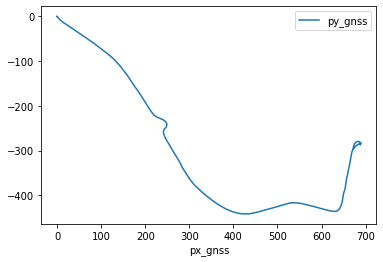

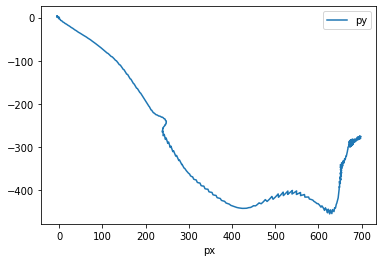

In [31]:
df.dropna().plot('px_gnss','py_gnss')
df.plot('px','py')

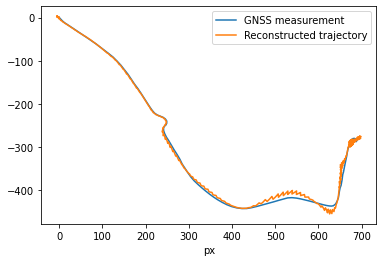

In [32]:
ax1 = df.dropna().plot('px_gnss','py_gnss',label ="GNSS measurement")
ax2 = df.plot('px','py', ax=ax1,label = "Reconstructed trajectory")

<AxesSubplot:xlabel='t'>

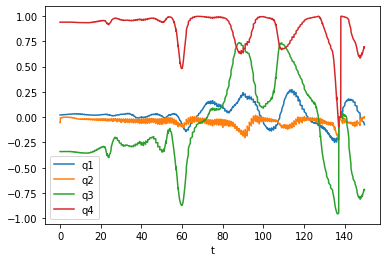

In [33]:
df.plot('t',[c for c in df.columns if "q" in c])